## from_GideonIlung_deeponet.ipynb

The forward problem is based on Poisson equation, and the map of interest is the one that takes Dirichlet boundary condition function to the solution of the PDE. The dmain is a triangular with a notch. The numerical solution and the implementation in Matlab is from the repository [deeponet-fno](https://github.com/lu-group/deeponet-fno/tree/main).

> For the implementation, we only need `Darcy_Triangulation.mat` which is included in the repository. 

> Dependencies can be installed using `neuralop.yml` file in the root directory of this repository. 

Notebook shows the implemntation of DeepONet following [DeepONet](https://github.com/GideonIlung/DeepONet) repository. We made few minor changes but the core implementation is from the mentioned source. This method uses `pytorch`.

In [1]:
import sys
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scipy.io as io

np.random.seed(1234)

import matplotlib.pyplot as plt

In [ ]:
data_folder = 'data/'
result_folder = 'Results_second_method/'
current_directory = os.getcwd()  
results_dir = current_directory + '/' + result_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Utilities function

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import Subplot
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable

def field_plot(ax, fn_nodal_values, nodes, elements = None, dim = 2, \
                        add_displacement_to_nodes = False, \
                        is_displacement = False, \
                        dbg_log = False, **kwargs):
    
    if dim != 2:
        raise ValueError("Only 2D plots are supported")
    
    if dbg_log:
        print('fn_nodal_values.shape = {}, nodes.shape = {}'.format(fn_nodal_values.shape, \
                                                                nodes.shape))
    
    n1, n2 = len(fn_nodal_values), 1
    if fn_nodal_values.ndim == 2:
        n2 = fn_nodal_values.shape[1]
    elif fn_nodal_values.ndim > 2: 
        raise ValueError("fn_nodal_values should be a 1D or 2D array")

    if n1 != nodes.shape[0]:
        raise ValueError("Number of nodes in the mesh and the number of dofs do not match")
    
    # Compute magnitude of the field
    C = None
    if fn_nodal_values.ndim == 1:
        C = fn_nodal_values[:]**2
    else:
        for i in range(n2):
            if i == 0:
                C = fn_nodal_values[:, i]**2
            else:
                C += fn_nodal_values[:, i]**2

    C = np.sqrt(C)

    # manipulate the configuration of the plot
    nodes_def = nodes
    if is_displacement:
        if n2 != 2:
            raise ValueError("Displacement should be a 2D array for dim = 2")

        if add_displacement_to_nodes:
            nodes_def = nodes + fn_nodal_values

    if dbg_log:
        print('nodes_def.shape = {}'.format(nodes_def.shape))
    
    triang = None
    if elements is not None:
        triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1], elements)
    else:
        triang = tri.Triangulation(nodes_def[:, 0], nodes_def[:, 1])

    shading = kwargs.pop("shading", "gouraud") # or 'shading', 'flat'

    cbar = ax.tripcolor(triang, C, shading=shading, **kwargs)

    return cbar

## Define network methods

In [4]:
class DataEncoderDecoder:
    def __init__(self, mean, std, tol = 1.0e-9):
        self.mean = mean
        self.std = std
        self.tol = tol

    def encoder(self, x):
        
        x = (x - self.mean)/(self.std + self.tol)
        return x   
    
    def decoder(self, x):
        
        x = x*(self.std + self.tol) + self.mean
        return x

In [5]:
class Datahandler(Dataset):
    def __init__(self, x_branch_, x_trunk_, y_):

        x_branch = self.convert_np_to_tensor(x_branch_)
        x_trunk = self.convert_np_to_tensor(x_trunk_)
        y = self.convert_np_to_tensor(y_)

        self.x_batch = x_branch
        self.x_trunk = x_trunk
        self.y = y

    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            # Convert NumPy array to PyTorch tensor
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array
    
    def __len__(self):
        return len(self.y)  # Assuming x_batch and x_trunk have the same length as y

    def __getitem__(self, index):
        return self.x_batch[index,:], self.x_trunk, self.y[index,:]

### MLP and Network classes

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, depth,act):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        
        #the activation function#
        self.act = act 

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        # Hidden layers
        for _ in range(depth - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_size, num_classes))
        
    def forward(self, x,final_act=False):
        for i in range(len(self.layers) - 1):
            x = self.act(self.layers[i](x))
        x = self.layers[-1](x)  # No activation after the last layer

        if final_act == False:
            return x
        else:
            return torch.relu(x)

In [7]:
class DeepONet(nn.Module):
    
    def __init__(self,n_branch:int,width:int,depth:int,p:int,act,n_trunk:int=1):

        super(DeepONet, self).__init__()

        #creating the branch network#
        self.branch_net = MLP(input_size=n_branch,hidden_size=width,num_classes=p,depth=depth,act=act)
        self.branch_net.float()

        #creating the trunk network#
        self.trunk_net = MLP(input_size=n_trunk,hidden_size=width,num_classes=p,depth=depth,act=act)
        self.trunk_net.float()
        
        self.bias = nn.Parameter(torch.ones((1,)),requires_grad=True)

        # Logger
        self.train_loss_log = []
        self.test_loss_log = []
    
    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            # Convert NumPy array to PyTorch tensor
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array

    
    def forward(self, batch):

        x_branch = self.convert_np_to_tensor(batch['branch_inp'])
        x_trunk = self.convert_np_to_tensor(batch['trunk_inp'])
        
        branch_out = self.branch_net.forward(x_branch)
        trunk_out = self.trunk_net.forward(x_trunk,final_act=True)

        output = branch_out @ trunk_out.t() + self.bias
        return output
    
    def train(self, train_data, test_data, batch_size=32, epochs = 1000, \
              lr:float=0.001, log=True):

        self.epochs = epochs
        self.batch_size = batch_size

        dataset = Datahandler(train_data['branch_inp'], \
                              train_data['trunk_inp'], train_data['y_out'])
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 

        trunk_inp = dataset.x_trunk

        test_data_tensor = {'branch_inp': self.convert_np_to_tensor(test_data['branch_inp']), \
                            'trunk_inp': self.convert_np_to_tensor(test_data['trunk_inp']), \
                            'y_out': self.convert_np_to_tensor(test_data['y_out'])}

        #using standard MSE loss
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)


        self.train_loss_log = np.zeros((epochs, 1))
        self.test_loss_log = np.zeros((epochs, 1))

        # Main training loop
        for epoch in range(epochs):
            
            train_losses = []
            test_losses = []

            start_time = time.perf_counter()

            for branch_inp, _, y_out in dataloader:

                # branch_inp = branch_inp.numpy()
                # y_out = y_out.numpy()

                # print(branch_inp.shape, trunk_inp.shape, y_out.shape)
                batch = {'branch_inp': branch_inp, 'trunk_inp': trunk_inp, 'y_out': y_out}
                
                #removing previous gradients#
                optimizer.zero_grad()

                #forward pass through model#
                y_pred = self.forward(batch)
                loss = criterion(y_pred, y_out)

                # Backward pass
                loss.backward()

                #calculate avg loss across batches#
                train_losses.append(loss.item())

                # Update parameters
                optimizer.step()

                # compute test loss
                y_test_pred = self.forward(test_data_tensor)
                test_loss = criterion(y_test_pred, test_data_tensor['y_out']).item()
                test_losses.append(test_loss)

            end_time = time.perf_counter()
            epoch_time = end_time - start_time

            self.train_loss_log[epoch, 0] = np.mean(train_losses)
            self.test_loss_log[epoch, 0] = np.mean(test_losses)

            if log == True:
                print('='*30)
                print('Epoch: {:5d}, Train Loss (rel l2): {:.3e}, Test Loss (rel l2): {:.3e}, Time (sec): {:.3f}'.format(epoch, \
                                                  np.mean(train_losses), \
                                                  np.mean(test_losses), \
                                                  epoch_time))
                print('='*30)
    
    def predict(self, test_data):
        test_data_tensor = {'branch_inp': self.convert_np_to_tensor(test_data['branch_inp']), \
                            'trunk_inp': self.convert_np_to_tensor(test_data['trunk_inp']), \
                            'y_out': self.convert_np_to_tensor(test_data['y_out'])}
        return self.forward(test_data_tensor)

## Process data

In [8]:
def process_data(num_train, num_test, inp_grid_points, out_grid_points):
    
    data = io.loadmat(data_folder + 'Darcy_Triangular')
    
    xx = data['xx']
    yy = data['yy']
    xx = np.reshape(xx, (-1, 1))
    yy = np.reshape(yy, (-1, 1))
    X_trunk = np.hstack((xx, yy))

    f_train = data['f_bc'][:num_train,:]
    u_train = data['u_field'][:num_train,:]

    f_test = data['f_bc'][num_train:(num_train + num_test),:]
    u_test = data['u_field'][num_train:(num_train + num_test),:]

    f_train_mean = np.mean(f_train, 0)
    f_train_std = np.std(f_train, 0)
    inp_decencoder = DataEncoderDecoder(f_train_mean, f_train_std)


    u_train_mean = np.mean(u_train, 0)
    u_train_std = np.std(u_train, 0)
    out_decencoder = DataEncoderDecoder(u_train_mean, u_train_std)

    # encode the data
    F_train = inp_decencoder.encoder(f_train)
    U_train = out_decencoder.encoder(u_train)
    F_test = inp_decencoder.encoder(f_test)
    U_test = out_decencoder.encoder(u_test)    

    return data, X_trunk, F_train, U_train, F_test, U_test, inp_decencoder, out_decencoder

In [9]:
num_train = 1900
num_test = 100

inp_grid_points = 101 # number of grid points for the input function
out_grid_points = 2397 # number of evaluations points for the output function
num_br_tr_outputs = 100 # number of outputs from the branch and trunk networks before they are multiplied

data, X_trunk, F_train, U_train, F_test, U_test, inp_decencoder, \
    out_decencoder = process_data(num_train, num_test, inp_grid_points, out_grid_points)

train_data = {'branch_inp': F_train, 'trunk_inp': X_trunk, 'y_out': U_train}
test_data = {'branch_inp': F_test, 'trunk_inp': X_trunk, 'y_out': U_test}

print('F_train:',F_train.shape)
print('U_train:',U_train.shape)
print('F_test:',F_test.shape)
print('U_test:',U_test.shape)
print('X_trunk:',X_trunk.shape)

F_train: (1900, 101)
U_train: (1900, 2397)
F_test: (100, 101)
U_test: (100, 2397)
X_trunk: (2397, 2)


## Create model and train the network

In [10]:
num_layers = 4
layer_width = 128
model = DeepONet(n_branch = inp_grid_points, n_trunk = 2, \
                 width = layer_width, depth = num_layers, \
                 p = num_br_tr_outputs, \
                 act=torch.relu)

In [11]:
# Create data set
batch_size = 100
epochs = 10000
lr = 1.0e-3

# Train
model.train(train_data, test_data, batch_size=batch_size, epochs = epochs, lr = lr)

Epoch:     0, Train Loss (rel l2): 9.722e-01, Test Loss (rel l2): 9.065e-01, Time (sec): 0.297
Epoch:     1, Train Loss (rel l2): 5.299e-01, Test Loss (rel l2): 5.149e-01, Time (sec): 0.264
Epoch:     2, Train Loss (rel l2): 4.756e-01, Test Loss (rel l2): 4.558e-01, Time (sec): 0.259
Epoch:     3, Train Loss (rel l2): 3.788e-01, Test Loss (rel l2): 3.593e-01, Time (sec): 0.271
Epoch:     4, Train Loss (rel l2): 2.051e-01, Test Loss (rel l2): 2.112e-01, Time (sec): 0.270
Epoch:     5, Train Loss (rel l2): 1.735e-01, Test Loss (rel l2): 1.790e-01, Time (sec): 0.263
Epoch:     6, Train Loss (rel l2): 1.492e-01, Test Loss (rel l2): 1.520e-01, Time (sec): 0.250
Epoch:     7, Train Loss (rel l2): 1.073e-01, Test Loss (rel l2): 1.142e-01, Time (sec): 0.240
Epoch:     8, Train Loss (rel l2): 8.968e-02, Test Loss (rel l2): 9.996e-02, Time (sec): 0.229
Epoch:     9, Train Loss (rel l2): 8.112e-02, Test Loss (rel l2): 9.054e-02, Time (sec): 0.234
Epoch:    10, Train Loss (rel l2): 7.187e-02, Test

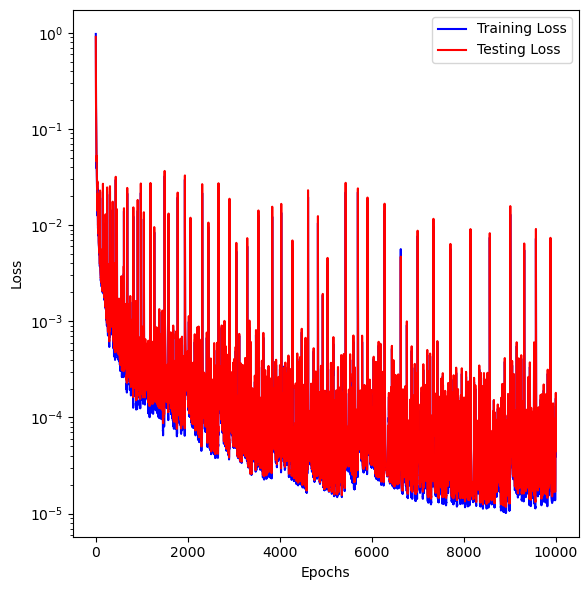

In [ ]:
## Plotting the loss history
num_epoch = model.train_loss_log.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, model.train_loss_log[:, 0], color='blue', label='Training Loss')
ax.plot(x, model.test_loss_log[:, 0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

## Test and plot the output of network

In [16]:
test_out = test_data['y_out']
test_pred = model.predict(test_data).detach().numpy()

print('test_out shape: {}, test_pred shape: {}'.format(test_out.shape, test_pred.shape))

error = np.linalg.norm(test_out - test_pred, axis = 1)/np.linalg.norm(test_out, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 2397), test_pred shape: (100, 2397)
Num tests:   100, Mean Loss (rel l2): 8.334e-03, Std Loss (rel l2): 3.203e-03


i_plot =     0, error (rel l2): 7.880e-03
i_plot =     1, error (rel l2): 7.317e-03
i_plot =     2, error (rel l2): 1.325e-02
i_plot =     3, error (rel l2): 7.422e-03
i_plot =     4, error (rel l2): 1.394e-02
i_plot =     5, error (rel l2): 8.719e-03
i_plot =     6, error (rel l2): 1.270e-02
i_plot =     7, error (rel l2): 7.316e-03
i_plot =     8, error (rel l2): 4.704e-03
i_plot =     9, error (rel l2): 8.878e-03
i_plot =    10, error (rel l2): 2.106e-02
i_plot =    11, error (rel l2): 8.056e-03
i_plot =    12, error (rel l2): 6.830e-03
i_plot =    13, error (rel l2): 7.446e-03
i_plot =    14, error (rel l2): 8.241e-03
i_plot =    15, error (rel l2): 1.196e-02


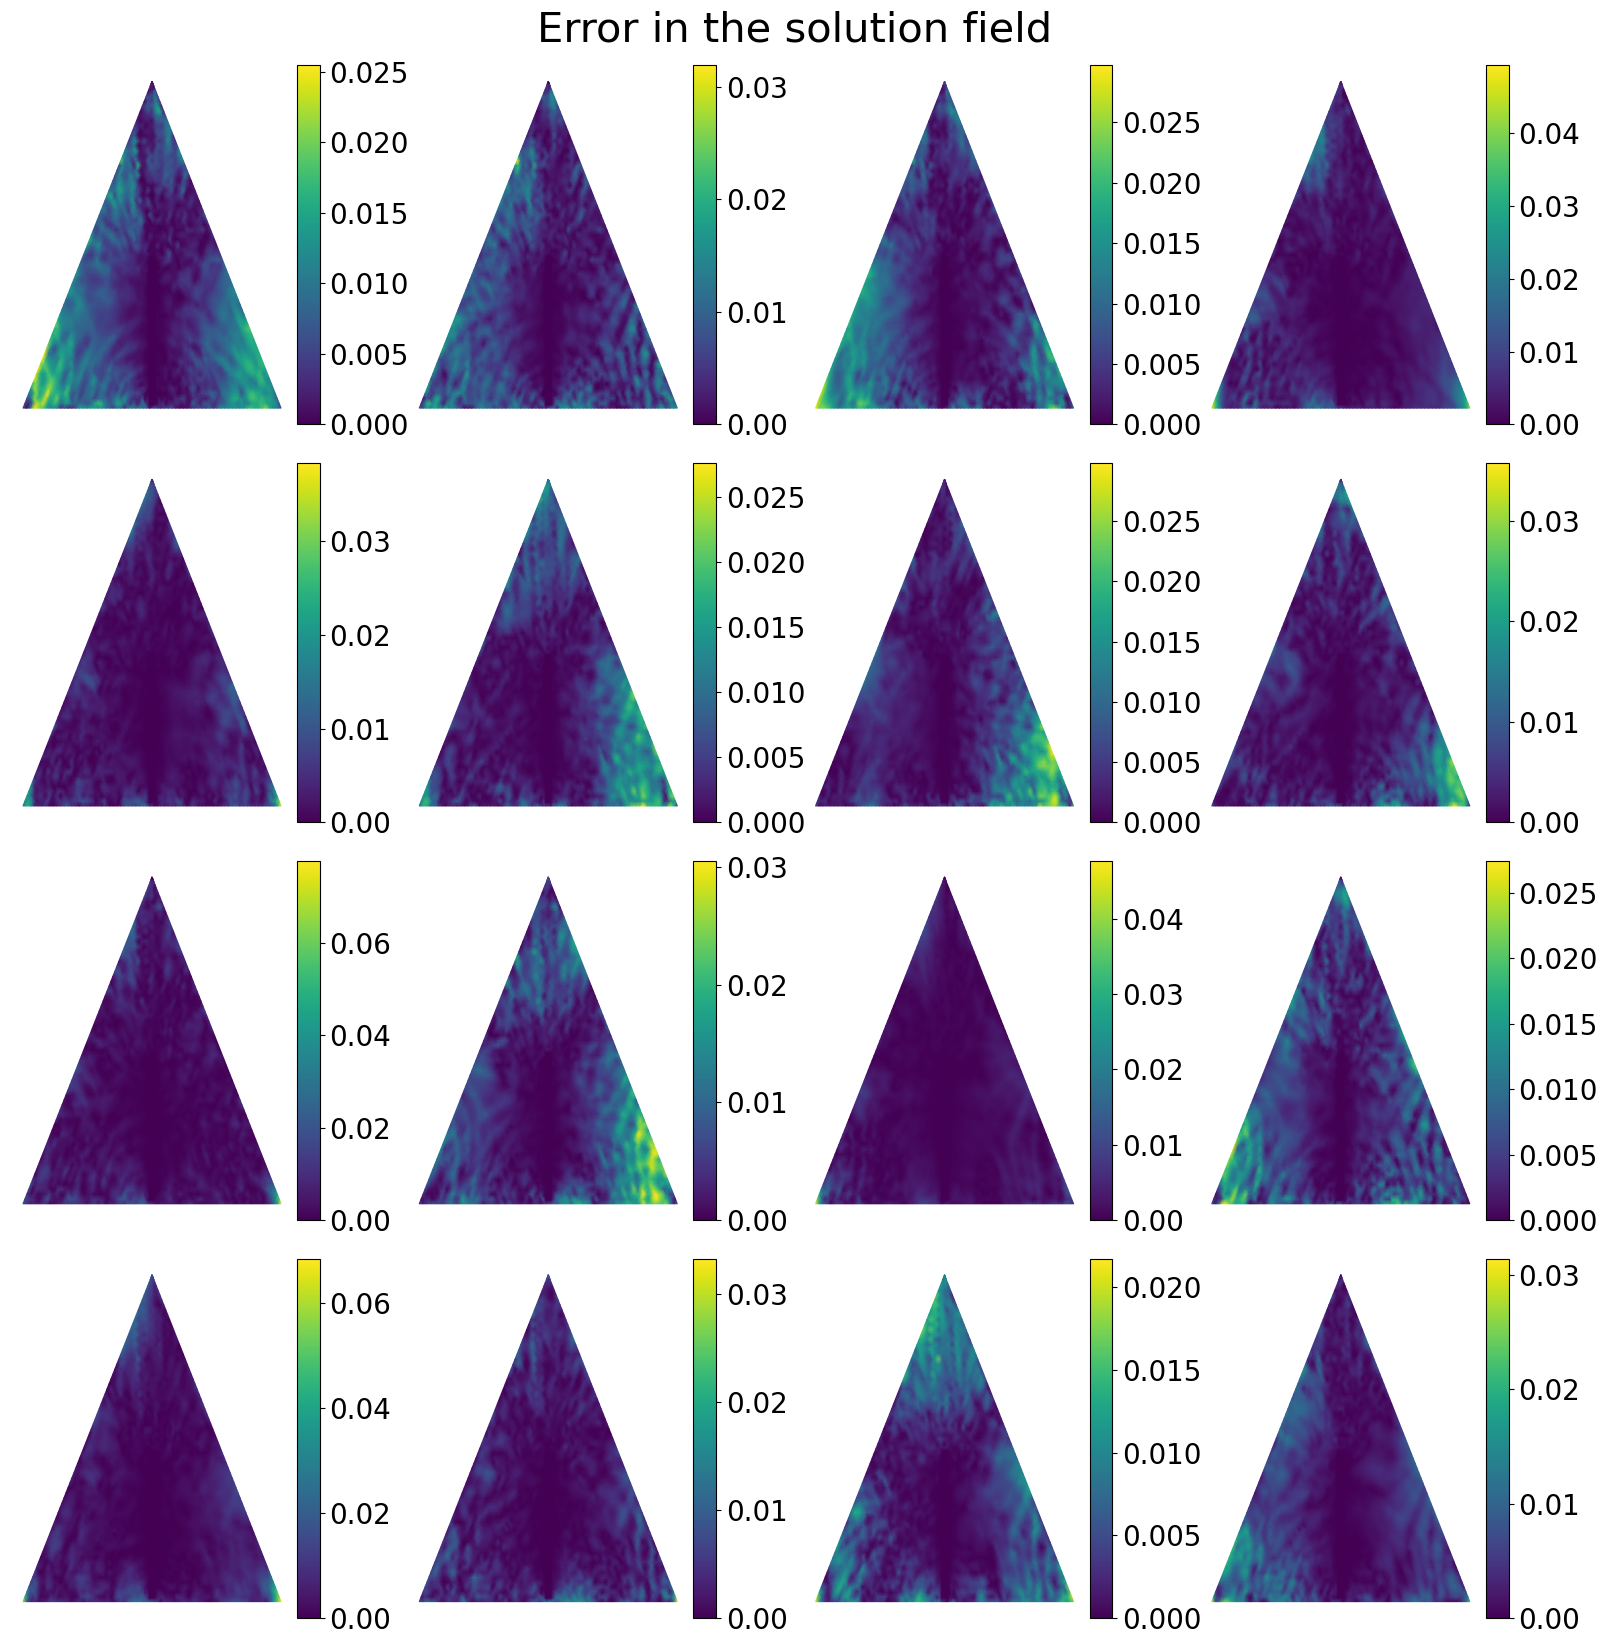

In [ ]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 16))

decode = True

for i in range(rows):
    for j in range(cols):
        i_plot = i*cols + j

        i_pred = test_pred[i_plot, :]
        i_truth = test_out[i_plot, :]
        if decode:
            i_pred = out_decencoder.decoder(i_pred)
            i_truth = out_decencoder.decoder(i_truth)

        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = X_trunk

        cbar = field_plot(axs[i,j], i_diff, nodes)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        fig.colorbar(cbar, cax=cax, orientation='vertical')

        axs[j,i].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'sample_error_plots.png',  bbox_inches='tight')
plt.show()
